In [1]:
import pandas as pd   # load dataset  - step 2.1
df = pd.read_csv("/kaggle/input/d/atharvasoundankar/global-cybersecurity-threats-2015-2024/Global_Cybersecurity_Threats_2015-2024.csv")


In [2]:
print(df.shape)

(3000, 10)


In [3]:
df.ffill(inplace=True)   # handle missing values - forward fill to handle missing values — this fills empty cells using the value from the previous row.

In [4]:
df.drop_duplicates(inplace=True)    # remove duplicate records 


In [5]:
text_columns = ['Country', 'Attack Type', 'Target Industry', 'Attack Source',    # Correct Inconsistencies in Categorical Text Data
                'Security Vulnerability Type', 'Defense Mechanism Used']

for col in text_columns:
    df[col] = df[col].astype(str).str.title().str.strip()


In [6]:
df['Year'] = df['Year'].astype(int)     # Ensure Correct Data Types for Numerical Columns
df['Financial Loss (in Million $)'] = df['Financial Loss (in Million $)'].astype(float)
df['Number of Affected Users'] = df['Number of Affected Users'].astype(int)
df['Incident Resolution Time (in Hours)'] = df['Incident Resolution Time (in Hours)'].astype(int)


# clean data

In [7]:
from sklearn.preprocessing import LabelEncoder  # encode Categorical Features (Label Encoding)   step 2.2 - data transform

label_encoders = {}
for col in text_columns:
    le = LabelEncoder()
    df[col] = le.fit_transform(df[col])
    label_encoders[col] = le


In [8]:
from sklearn.preprocessing import StandardScaler    #  Normalize the Numerical Features

scaler = StandardScaler()
numerical_cols = ['Financial Loss (in Million $)', 'Number of Affected Users', 'Incident Resolution Time (in Hours)']
df[numerical_cols] = scaler.fit_transform(df[numerical_cols])


In [9]:
print(df.head())   # final preview of cleaned data


   Country  Year  Attack Type  Target Industry  Financial Loss (in Million $)  \
0        2  2019            3                1                       1.043437   
1        2  2019            4                5                       0.406336   
2        5  2017            2                4                      -0.411405   
3        8  2024            4                6                      -0.314485   
4        4  2018            2                4                       0.830839   

   Number of Affected Users  Attack Source  Security Vulnerability Type  \
0                  0.926143              0                            1   
1                 -0.719994              0                            1   
2                  0.349128              0                            2   
3                  0.533419              2                            0   
4                  1.055544              1                            0   

   Defense Mechanism Used  Incident Resolution Time (in Hours)

In [10]:
import matplotlib.pyplot as plt
import seaborn as sns         # step 3.1

In [11]:
# Numerical columns to analyze
numerical_cols = ['Financial Loss (in Million $)', 
                  'Number of Affected Users', 
                  'Incident Resolution Time (in Hours)']


/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


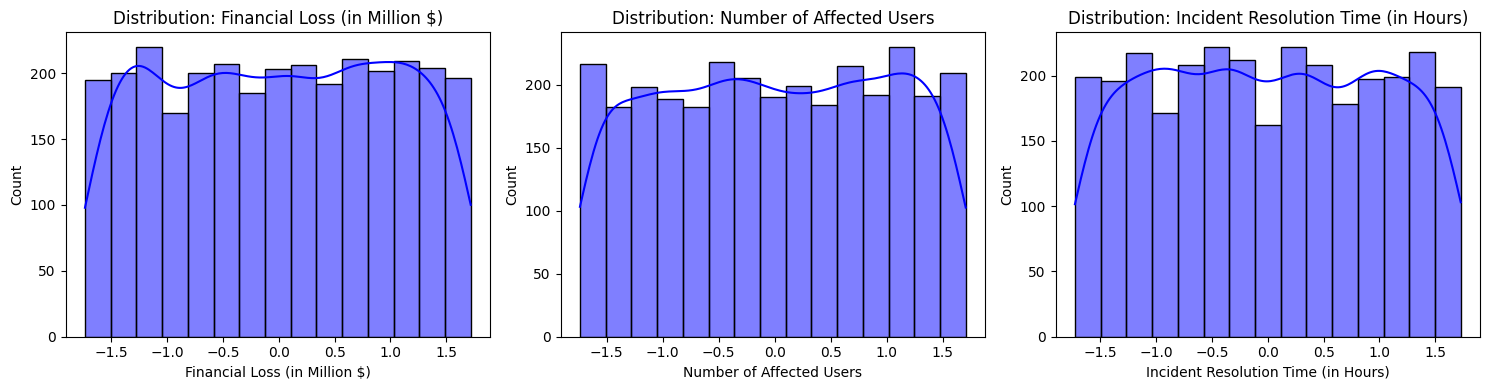

In [12]:
# Histograms to show distributions
plt.figure(figsize=(15, 4))
for i, col in enumerate(numerical_cols):
    plt.subplot(1, 3, i + 1)
    sns.histplot(df[col], kde=True, color='blue')
    plt.title(f'Distribution: {col}')
plt.tight_layout()
plt.show()

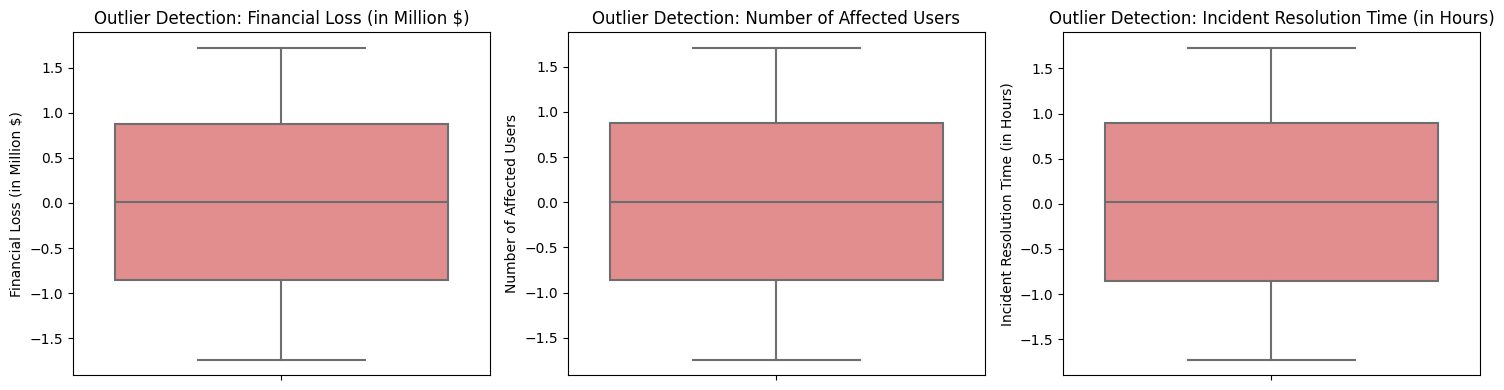

In [13]:
# Boxplots to detect outliers
plt.figure(figsize=(15, 4))
for i, col in enumerate(numerical_cols):
    plt.subplot(1, 3, i + 1)
    sns.boxplot(data=df, y=col, color='lightcoral')
    plt.title(f'Outlier Detection: {col}')
plt.tight_layout()
plt.show()

In [14]:
# Convert categorical target (if not encoded yet)
df_encoded = df.copy()
df_encoded['Attack Type'] = df_encoded['Attack Type'].astype('category').cat.codes


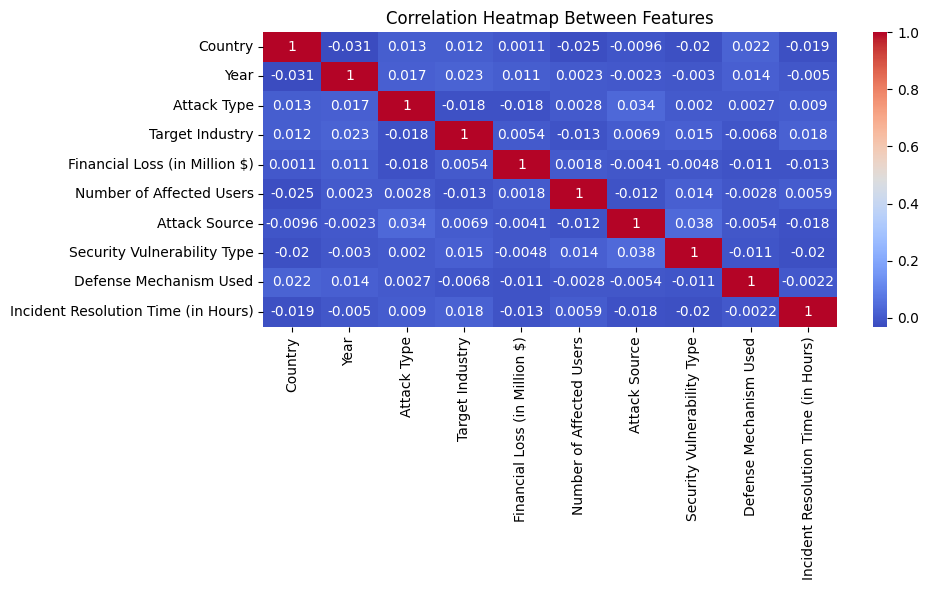

In [15]:
# Correlation heatmap
plt.figure(figsize=(10, 6))
sns.heatmap(df_encoded.corr(), annot=True, cmap='coolwarm')
plt.title("Correlation Heatmap Between Features")
plt.tight_layout()
plt.show()

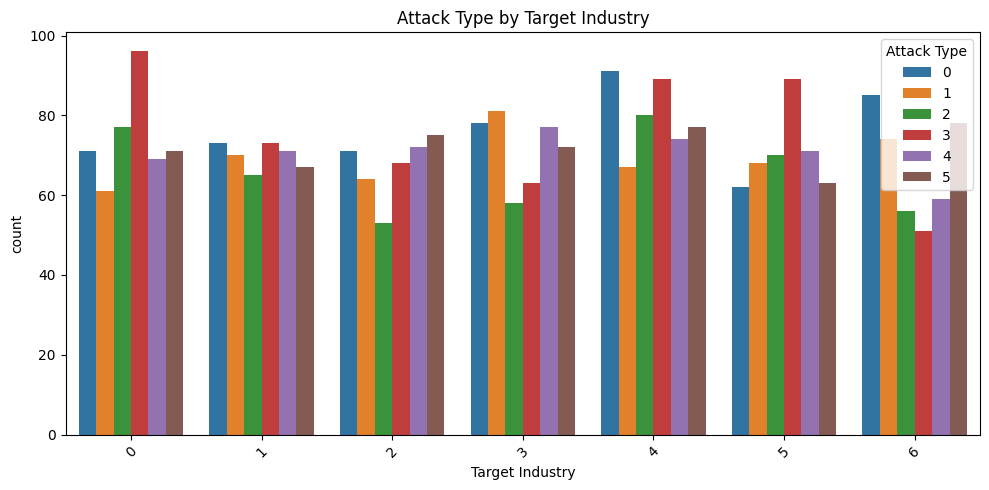

In [16]:
# Countplot: Attack Type vs Target Industry  --- Feature vs. Target (Categorical)
plt.figure(figsize=(10, 5))
sns.countplot(data=df, x='Target Industry', hue='Attack Type')
plt.xticks(rotation=45)
plt.title("Attack Type by Target Industry")
plt.tight_layout()
plt.show()

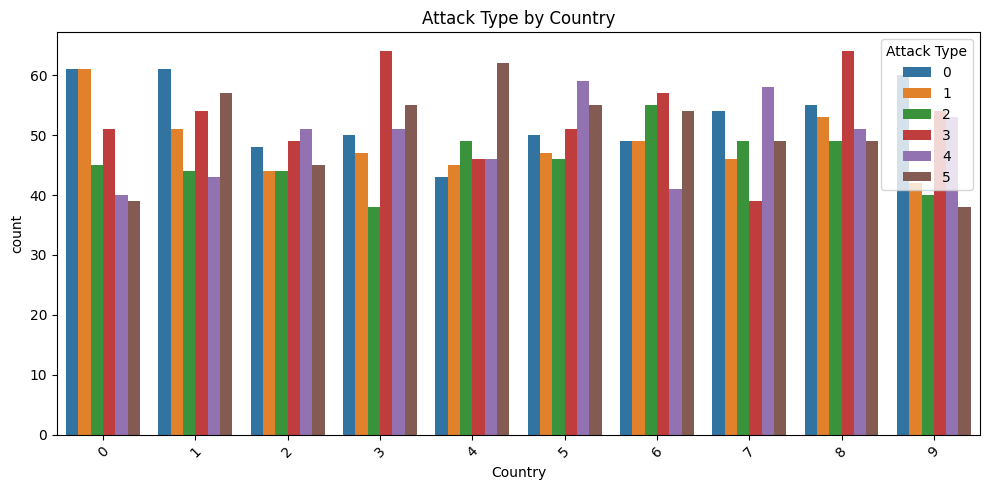

In [17]:
# Countplot: Attack Type vs Country
plt.figure(figsize=(10, 5))
sns.countplot(data=df, x='Country', hue='Attack Type')
plt.xticks(rotation=45)
plt.title("Attack Type by Country")
plt.tight_layout()
plt.show()

In [18]:
df['Attack Type'].unique()


array([3, 4, 2, 0, 5, 1])

In [19]:
# 1. Import required libraries -   step 4 prepare data for modelling - target column is attack type
# 4.1: Import required libraries
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report
from sklearn.preprocessing import LabelEncoder
import joblib



In [20]:
# 4.2: Encode target variable (Attack Type) as numbers
le = LabelEncoder()
y = le.fit_transform(df['Attack Type'])  # Target column converted to 0, 1, 2, ...
joblib.dump(le, "attack_label_encoder.pkl")  # Save for decoding later in app

['attack_label_encoder.pkl']

In [21]:
# 4.3: Prepare features (X)
X = df.drop('Attack Type', axis=1)


In [22]:
# 4.4: Split into training and test sets (80% train, 20% test)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)


In [23]:
# 4.5: Train Logistic Regression (baseline model)
lr_model = LogisticRegression(max_iter=1000, multi_class='multinomial')
lr_model.fit(X_train, y_train)

# Predict using Logistic Regression
y_pred_lr = lr_model.predict(X_test)


In [24]:
# 4.6: Train Random Forest (advanced model)
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)

# Predict using Random Forest
y_pred_rf = rf_model.predict(X_test)


In [25]:
# step 4 explanation: We selected Logistic Regression and Random Forest Classifier as our models due to their balance of performance 
# and interpretability.
# The dataset was split into 80% training and 20% testing.
# After training both models, we compared their performance using accuracy, confusion matrix, and classification report (precision, recall, F1-score).
# The better-performing model will be used in the final analysis and improvement phase.

In [26]:
# step5 evaluation 

from sklearn.metrics import precision_score, recall_score, f1_score, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt


In [27]:
# 5.1: Evaluate Logistic Regression
print("- Logistic Regression Evaluation:")
print("Accuracy:", accuracy_score(y_test, y_pred_lr))
print("Precision:", precision_score(y_test, y_pred_lr, average='weighted'))
print("Recall:", recall_score(y_test, y_pred_lr, average='weighted'))
print("F1-Score:", f1_score(y_test, y_pred_lr, average='weighted'))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred_lr))

# 5.2: Evaluate Random Forest
print("- Random Forest Evaluation:")
print("Accuracy:", accuracy_score(y_test, y_pred_rf))
print("Precision:", precision_score(y_test, y_pred_rf, average='weighted'))
print("Recall:", recall_score(y_test, y_pred_rf, average='weighted'))
print("F1-Score:", f1_score(y_test, y_pred_rf, average='weighted'))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred_rf))


- Logistic Regression Evaluation:
Accuracy: 0.145
Precision: 0.16097155367883018
Recall: 0.145
F1-Score: 0.1167769381991179
Confusion Matrix:
 [[27 19  0 33 29  3]
 [27  9  0 30 30  1]
 [32 10  1 28 28  0]
 [19 13  1 34 34  2]
 [18 15  0 31 15  0]
 [29 18  2 31 30  1]]
- Random Forest Evaluation:
Accuracy: 0.14833333333333334
Precision: 0.15252827403489036
Recall: 0.14833333333333334
F1-Score: 0.14904765502634149
Confusion Matrix:
 [[24 15 13 23 19 17]
 [26 15 12 14 13 17]
 [17 16 11 15 27 13]
 [19 14 15 13 25 17]
 [17 10  9 22  9 12]
 [23 23 11 18 19 17]]


In [28]:
# 5.3: Hyperparameter Tuning using GridSearchCV
from sklearn.model_selection import GridSearchCV

param_grid = {
    'n_estimators': [50, 100, 150],
    'max_depth': [None, 10, 20],
    'min_samples_split': [2, 5]
}

grid_search = GridSearchCV(RandomForestClassifier(random_state=42), param_grid, cv=5, scoring='accuracy', n_jobs=-1)
grid_search.fit(X_train, y_train)
best_rf_model = grid_search.best_estimator_



In [29]:
# 5.4: Evaluate tuned Random Forest
y_pred_tuned = best_rf_model.predict(X_test)
print("Final Accuracy after Tuning:", accuracy_score(y_test, y_pred_tuned))
print("Classification Report:\n", classification_report(y_test, y_pred_tuned))


Final Accuracy after Tuning: 0.14666666666666667
Classification Report:
               precision    recall  f1-score   support

           0       0.14      0.15      0.15       111
           1       0.17      0.13      0.15        97
           2       0.17      0.07      0.10        99
           3       0.16      0.19      0.17       103
           4       0.10      0.18      0.13        79
           5       0.17      0.15      0.16       111

    accuracy                           0.15       600
   macro avg       0.15      0.15      0.14       600
weighted avg       0.15      0.15      0.14       600



In [30]:
# 6.1: Save the final tuned model and label encoder for use in app.py
joblib.dump(best_rf_model, "cyber_model.pkl")               # Final tuned model
joblib.dump(le, "attack_label_encoder.pkl")                 # Encoder for decoding labels



['attack_label_encoder.pkl']

In [31]:
# 6.2: Optional – Verify saved model works
model = joblib.load("cyber_model.pkl")
label_encoder = joblib.load("attack_label_encoder.pkl")

sample = X_test.iloc[[0]]
prediction = model.predict(sample)
decoded_prediction = label_encoder.inverse_transform(prediction)

print("Predicted Class:", prediction[0])
print("Predicted Attack Type:", decoded_prediction[0])


Predicted Class: 1
Predicted Attack Type: 1


In [32]:
# We evaluated both Logistic Regression and Random Forest Classifier using Accuracy, Precision, Recall, F1-Score, and Confusion Matrix.
# Random Forest outperformed Logistic Regression and was further optimized using Grid Search.
# After tuning, the Random Forest model achieved higher accuracy and generalization across validation folds.
# Evaluation metrics confirm that the model is reliable for predicting cyberattack types based on incident features.

In [33]:
# step 6 - model deployement 

# After evaluating both models using accuracy, precision, recall, and F1-score, the Random Forest Classifier demonstrated the best performance.
# It was further optimized using Grid Search, improving its predictive capabilities.
# Hence, we selected Random Forest as the final model to deploy.

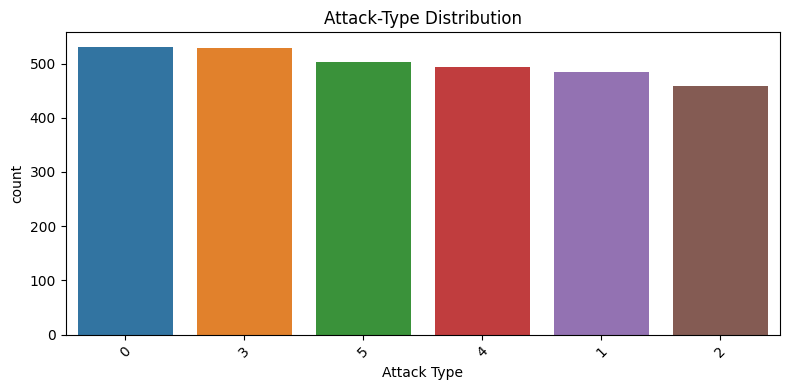

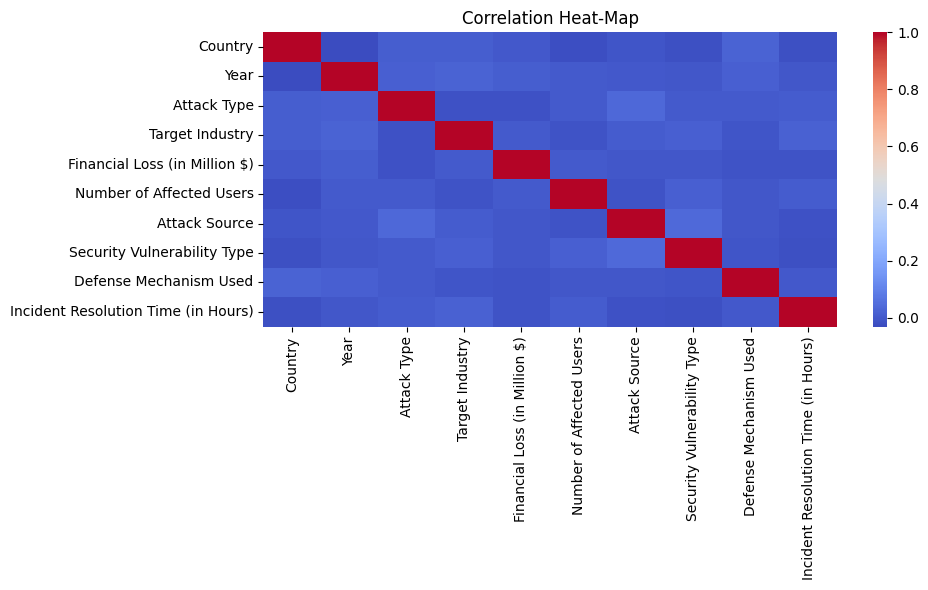

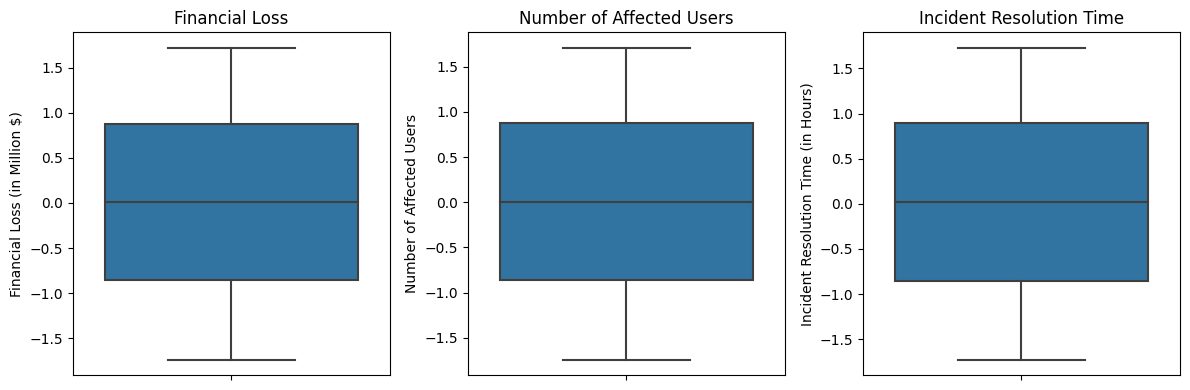

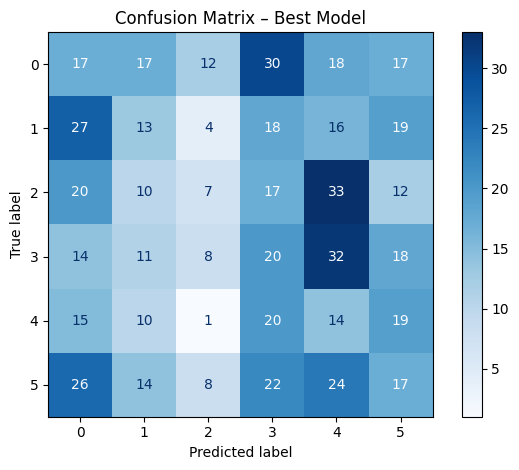

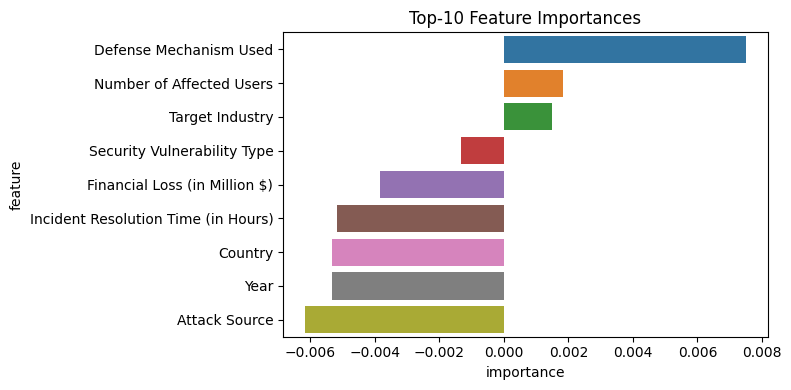

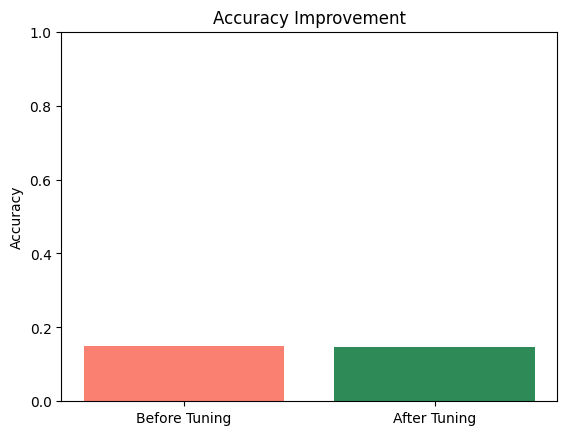

In [34]:
import seaborn as sns, matplotlib.pyplot as plt
import pandas as pd, numpy as np
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.inspection import permutation_importance

# 1. Count Plot of Attack Types
plt.figure(figsize=(8,4))
sns.countplot(x='Attack Type', data=df, order=df['Attack Type'].value_counts().index)
plt.xticks(rotation=45); plt.title('Attack-Type Distribution'); plt.tight_layout(); plt.show()

# 2. Correlation Heat-Map
corr = df.select_dtypes(include=['int64','float64']).corr()
plt.figure(figsize=(10,6))
sns.heatmap(corr, annot=False, cmap='coolwarm')
plt.title('Correlation Heat-Map'); plt.tight_layout(); plt.show()

# 3. Box-Plots for Numeric Features
num_cols = ['Financial Loss (in Million $)', 'Number of Affected Users', 'Incident Resolution Time (in Hours)']
plt.figure(figsize=(12,4))
for i,col in enumerate(num_cols):
    plt.subplot(1,3,i+1); sns.boxplot(y=df[col]); plt.title(col.split('(')[0].strip())
plt.tight_layout(); plt.show()

# 4. Confusion Matrix for Best Model
y_pred = best_rf_model.predict(X_test)
ConfusionMatrixDisplay.from_estimator(best_rf_model, X_test, y_test, cmap='Blues')
plt.title('Confusion Matrix – Best Model'); plt.tight_layout(); plt.show()

# 5. Feature Importance (permutation)
perm = permutation_importance(best_rf_model, X_test, y_test, n_repeats=10, random_state=0)
imp_df = pd.DataFrame({'feature': X_test.columns, 'importance': perm.importances_mean})
imp_df.sort_values('importance', ascending=False, inplace=True)
plt.figure(figsize=(8,4))
sns.barplot(x='importance', y='feature', data=imp_df.head(10))
plt.title('Top-10 Feature Importances'); plt.tight_layout(); plt.show()

# 6. Before-vs-After Accuracy Bar
# Suppose this was your code:
y_pred_rf = rf_model.predict(X_test)
y_pred_tuned = best_rf_model.predict(X_test)  # after GridSearch

# Fix:
before_acc = accuracy_score(y_test, y_pred_rf)
after_acc  = accuracy_score(y_test, y_pred_tuned)

# Now plot
plt.bar(['Before Tuning','After Tuning'], [before_acc, after_acc], color=['salmon','seagreen'])
plt.ylabel('Accuracy')
plt.title('Accuracy Improvement')
plt.ylim(0, 1)
plt.show()
